# Workflows

In Pydra, workflows are DAG of component tasks to be executed on specified inputs.
Workflow definitions are dataclasses, which interchangeable with Python and shell tasks
definitions and executed in the same way.

## Constructor functions

Workflows are typically defined using the `pydra.compose.workflow.define` decorator on 
a "constructor" function that generates the workflow. For example, given two task
definitions, `Add` and `Mul`.

In [1]:
from pydra.compose import workflow, python
from pydra.utils import show_workflow, print_help


# Example python tasks
@python.define
def Add(a, b):
    return a + b


@python.define
def Mul(a, b):
    return a * b

 we can create a simple workflow definition using `workflow.define` to decorate a function that constructs the workflow. Nodes are added to the workflow being constructed by calling `workflow.add` function.

--------------------------------------
Help for Workflow task 'BasicWorkflow'
--------------------------------------

Inputs:
- a: Any
- b: Any
- constructor: Callable[]; default = BasicWorkflow()

Outputs:
- out: Any



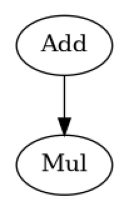

In [2]:
@workflow.define
def BasicWorkflow(a, b):
    add = workflow.add(Add(a=a, b=b))
    mul = workflow.add(Mul(a=add.out, b=b))
    return mul.out


print_help(BasicWorkflow)
show_workflow(BasicWorkflow, figsize=(2, 2.5))

`workflow.add` returns an "outputs" object corresponding to the definition added to the
workflow. The fields of the outptus object can be referenced as inputs to downstream
workflow nodes. Note that these output fields are just placeholders for the values that will
be returned and can't be used in conditional statements during workflow construction
(see [Dynamic construction](../explanation/conditional-lazy.html) on how to work around this
limitation). The fields of the outputs to be returned by the workflow should be returned
in a tuple.

--------------------------------------
Help for Workflow task 'ShellWorkflow'
--------------------------------------

Inputs:
- input_video: video/mp4
- watermark: image/png
- watermark_dims: tuple[int, int]; default = (10, 10)
- constructor: Callable[]; default = ShellWorkflow()

Outputs:
- out: video/mp4



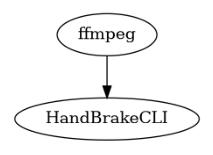

In [3]:
from pydra.compose import shell
from fileformats import image, video


@workflow.define
def ShellWorkflow(
    input_video: video.Mp4,
    watermark: image.Png,
    watermark_dims: tuple[int, int] = (10, 10),
) -> video.Mp4:

    add_watermark = workflow.add(
        shell.define(
            "ffmpeg -i <in_video> -i <watermark:image/png> "
            "-filter_complex <filter> <out|out_video>"
        )(
            in_video=input_video,
            watermark=watermark,
            filter="overlay={}:{}".format(*watermark_dims),
        )
    )
    output_video = workflow.add(
        shell.define(
            "HandBrakeCLI -i <in_video:video/mp4> -o <out|out_video:video/mp4> "
            "--width <width:int> --height <height:int>",
        )(in_video=add_watermark.out_video, width=1280, height=720)
    ).out_video

    return output_video  # test implicit detection of output name


print_help(ShellWorkflow)
show_workflow(ShellWorkflow, figsize=(2.5, 3))

## Splitting/combining task inputs

Sometimes, you might want to perform the same task over a set of input values/files, and then collect the results into a list to perform further processing. This can be achieved by using the `split` and `combine` methods

--------------------------------------
Help for Workflow task 'SplitWorkflow'
--------------------------------------

Inputs:
- a: list[int]
- b: list[float]
- constructor: Callable[]; default = SplitWorkflow()

Outputs:
- out: list[float]



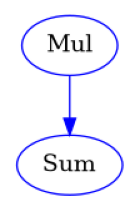

In [4]:
@python.define
def Sum(x: list[float]) -> float:
    return sum(x)


@workflow.define
def SplitWorkflow(a: list[int], b: list[float]) -> list[float]:
    # Multiply over all combinations of the elements of a and b, then combine the results
    # for each a element into a list over each b element
    mul = workflow.add(Mul().split(a=a, b=b).combine("a"))
    # Sume the multiplications across all all b elements for each a element
    sum = workflow.add(Sum(x=mul.out))
    return sum.out


print_help(SplitWorkflow)
show_workflow(SplitWorkflow, figsize=(2, 2.5))

The combination step doesn't have to be done on the same step as the split, in which case the splits propagate to downstream nodes

-------------------------------------------------
Help for Workflow task 'SplitThenCombineWorkflow'
-------------------------------------------------

Inputs:
- a: list[int]
- b: list[float]
- c: float
- constructor: Callable[]; default = SplitThenCombineWorkflow()

Outputs:
- out: list[float]



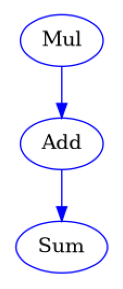

In [5]:
@workflow.define
def SplitThenCombineWorkflow(a: list[int], b: list[float], c: float) -> list[float]:
    mul = workflow.add(Mul().split(a=a, b=b))
    add = workflow.add(Add(a=mul.out, b=c).combine("Mul.a"))
    sum = workflow.add(Sum(x=add.out))
    return sum.out


print_help(SplitThenCombineWorkflow)
show_workflow(SplitThenCombineWorkflow, figsize=(3, 3.5))

For more advanced discussion on the intricacies of splitting and combining see [Splitting and combining](../explanation/splitting-combining.html)

## Nested and conditional workflows

One of the most powerful features of Pydra is the ability to use inline Python code to conditionally add/omit nodes to workflow, and alter the parameterisation of the nodes, depending on inputs to the workflow 

--------------------------------------------
Help for Workflow task 'ConditionalWorkflow'
--------------------------------------------

Inputs:
- input_video: video/mp4
- watermark: image/png
- watermark_dims: tuple[int, int] | None; default = None
- constructor: Callable[]; default = ConditionalWorkflow()

Outputs:
- out: video/mp4



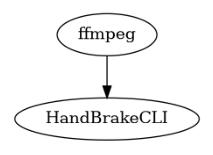

In [6]:
@workflow.define
def ConditionalWorkflow(
    input_video: video.Mp4,
    watermark: image.Png,
    watermark_dims: tuple[int, int] | None = None,
) -> video.Mp4:

    if watermark_dims is not None:
        add_watermark = workflow.add(
            shell.define(
                "ffmpeg -i <in_video> -i <watermark:image/png> "
                "-filter_complex <filter> <out|out_video>"
            )(
                in_video=input_video,
                watermark=watermark,
                filter="overlay={}:{}".format(*watermark_dims),
            )
        )
        handbrake_input = add_watermark.out_video
    else:
        handbrake_input = input_video

    output_video = workflow.add(
        shell.define(
            "HandBrakeCLI -i <in_video:video/mp4> -o <out|out_video:video/mp4> "
            "--width <width:int> --height <height:int>",
        )(in_video=handbrake_input, width=1280, height=720)
    ).out_video

    return output_video  # test implicit detection of output name


print_help(ConditionalWorkflow)
show_workflow(ConditionalWorkflow(watermark_dims=(10, 10)), figsize=(2.5, 3))

Note that outputs of upstream nodes cannot be used in conditional statements, since these are just placeholders at the time the workflow is being constructed. However, you can get around
this limitation by placing the conditional logic within a nested workflow

In [7]:
@python.define
def Subtract(x: float, y: float) -> float:
    return x - y


@workflow.define
def RecursiveNestedWorkflow(a: float, depth: int) -> float:
    add = workflow.add(Add(a=a, b=1))
    decrement_depth = workflow.add(Subtract(x=depth, y=1))
    if depth > 0:
        out_node = workflow.add(
            RecursiveNestedWorkflow(a=add.out, depth=decrement_depth.out)
        )
    else:
        out_node = add
    return out_node.out


print_help(RecursiveNestedWorkflow)

------------------------------------------------
Help for Workflow task 'RecursiveNestedWorkflow'
------------------------------------------------

Inputs:
- a: float
- depth: int
- constructor: Callable[]; default = RecursiveNestedWorkflow()

Outputs:
- out: float



For more detailed discussion of the construction of conditional workflows and "lazy field"
placeholders see [Conditionals and lazy fields](../explanation/conditional-lazy.html)

## Type-checking between nodes

Pydra utilizes Python type annotations to implement strong type-checking, which is performed
when values or upstream outputs are assigned to task inputs.

Job input and output fields do not need to be assigned types, since they will default to `typing.Any`.
However, if they are assigned a type and a value or output from an upstream node conflicts
with the type, a `TypeError` will be raised at construction time.

Note that the type-checking "assumes the best", and will pass if the upstream field is typed
by `Any` or a super-class of the field being assigned to. For example, an input of
`fileformats.generic.File` passed to a field expecting a `fileformats.image.Png` file type,
because `Png` is a subtype of `File`, where as `fileformats.image.Jpeg` input would fail
since it is clearly not the intended type.


------------------------------------------
Help for Workflow task 'TypeErrorWorkflow'
------------------------------------------

Inputs:
- input_video: video/mp4
- watermark: generic/file
- watermark_dims: tuple[int, int]; default = (10, 10)
- constructor: Callable[]; default = TypeErrorWorkflow()

Outputs:
- out: video/mp4



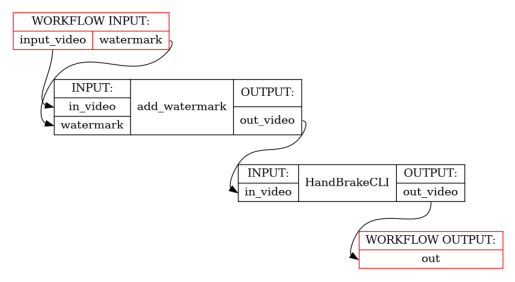

In [8]:
from fileformats import generic

Mp4Handbrake = shell.define(
    "HandBrakeCLI -i <in_video:video/mp4> -o <out|out_video:video/mp4> "
    "--width <width:int> --height <height:int>",
)


QuicktimeHandbrake = shell.define(
    "HandBrakeCLI -i <in_video:video/quicktime> -o <out|out_video:video/quicktime> "
    "--width <width:int> --height <height:int>",
)


@workflow.define
def TypeErrorWorkflow(
    input_video: video.Mp4,
    watermark: generic.File,
    watermark_dims: tuple[int, int] = (10, 10),
) -> video.Mp4:

    add_watermark = workflow.add(
        shell.define(
            "ffmpeg -i <in_video> -i <watermark:image/png> "
            "-filter_complex <filter> <out|out_video:video/mp4>"
        )(
            in_video=input_video,  # This is OK because in_video is typed Any
            watermark=watermark,  # Type is OK because generic.File is superclass of image.Png
            filter="overlay={}:{}".format(*watermark_dims),
        ),
        name="add_watermark",
    )

    try:
        handbrake = workflow.add(
            QuicktimeHandbrake(
                in_video=add_watermark.out_video, width=1280, height=720
            ),
        )  # This will raise a TypeError because the input video is an Mp4
    except TypeError:
        handbrake = workflow.add(
            Mp4Handbrake(in_video=add_watermark.out_video, width=1280, height=720),
        )  # The type of the input video is now correct

    return handbrake.out_video


print_help(TypeErrorWorkflow)
show_workflow(TypeErrorWorkflow, plot_type="detailed")

For more detailed discussion on Pydra's type-checking see [Type Checking](../explanation/typing.html).

## Accessing the workflow object

If you need to access the workflow object being constructed from inside the constructor function you can use `workflow.this()`.

--------------------------------------------
Help for Workflow task 'DirectAccesWorkflow'
--------------------------------------------

Inputs:
- a: int
    An integer input
- b: float
    A float input
- constructor: Callable[]; default = DirectAccesWorkflow()

Outputs:
- out1: float
    The first output
- out2: float
    The second output



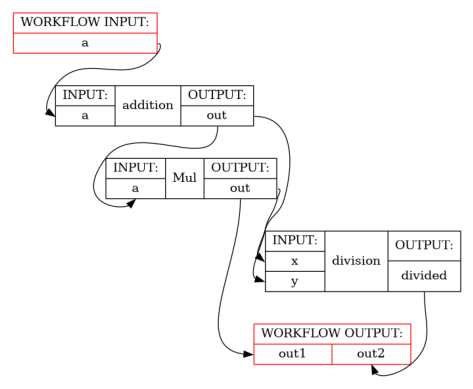

In [9]:
@python.define(outputs=["divided"])
def Divide(x, y):
    return x / y


@workflow.define(outputs=["out1", "out2"])
def DirectAccesWorkflow(a: int, b: float) -> tuple[float, float]:
    """A test workflow demonstration a few alternative ways to set and connect nodes

    Args:
        a: An integer input
        b: A float input

    Returns:
        out1: The first output
        out2: The second output
    """

    wf = workflow.this()

    add = wf.add(Add(a=a, b=b), name="addition")
    mul = wf.add(Mul(a=add.out, b=b))
    divide = wf.add(Divide(x=wf["addition"].lzout.out, y=mul.out), name="division")

    # Alter one of the inputs to a node after it has been initialised
    wf["Mul"].inputs.b *= 2

    return mul.out, divide.divided


print_help(DirectAccesWorkflow)
show_workflow(DirectAccesWorkflow(b=1), plot_type="detailed")

Directly access the workflow being constructed also enables you to set the outputs of the workflow directly

---------------------------------------------
Help for Workflow task 'SetOutputsOfWorkflow'
---------------------------------------------

Inputs:
- a: int
    An integer input
- b: float
    A float input
- constructor: Callable[]; default = SetOutputsOfWorkflow()

Outputs:
- out1: float
    The first output
- out2: float
    The second output



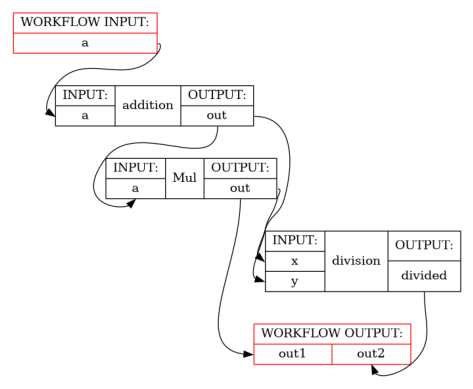

In [10]:
@workflow.define(outputs={"out1": float, "out2": float})
def SetOutputsOfWorkflow(a: int, b: float):
    """A test workflow demonstration a few alternative ways to set and connect nodes

    Args:
        a: An integer input
        b: A float input

    Returns:
        out1: The first output
        out2: The second output
    """

    wf = workflow.this()

    add = wf.add(Add(a=a, b=b), name="addition")
    mul = wf.add(Mul(a=add.out, b=b))
    divide = wf.add(Divide(x=wf["addition"].lzout.out, y=mul.out), name="division")

    # Alter one of the inputs to a node after it has been initialised
    wf["Mul"].inputs.b *= 2

    # Set the outputs of the workflow directly
    wf.outputs.out1 = mul.out
    wf.outputs.out2 = divide.divided


print_help(SetOutputsOfWorkflow)
show_workflow(SetOutputsOfWorkflow(b=3), plot_type="detailed")

## Setting software environments per node

The [Advanced execution tutorial](./2-advanced-execution.html) showed how the software
environment (e.g. Docker container) could be specified for shell tasks by passing the
`environment` variable to the task execution/submission call. For shell tasks
within workflows, the software environment used for them is specified when adding
a new workflow node, i.e.

In [11]:
import tempfile
from pathlib import Path
import numpy as np
from fileformats.medimage import Nifti1
import fileformats.vendor.mrtrix3.medimage as mrtrix3
from pydra.environments import docker
from pydra.compose import workflow, python
from pydra.tasks.mrtrix3.v3_1 import MrConvert, MrThreshold

MRTRIX2NUMPY_DTYPES = {
    "Int8": np.dtype("i1"),
    "UInt8": np.dtype("u1"),
    "Int16LE": np.dtype("<i2"),
    "Int16BE": np.dtype(">i2"),
    "UInt16LE": np.dtype("<u2"),
    "UInt16BE": np.dtype(">u2"),
    "Int32LE": np.dtype("<i4"),
    "Int32BE": np.dtype(">i4"),
    "UInt32LE": np.dtype("<u4"),
    "UInt32BE": np.dtype(">u4"),
    "Float32LE": np.dtype("<f4"),
    "Float32BE": np.dtype(">f4"),
    "Float64LE": np.dtype("<f8"),
    "Float64BE": np.dtype(">f8"),
    "CFloat32LE": np.dtype("<c8"),
    "CFloat32BE": np.dtype(">c8"),
    "CFloat64LE": np.dtype("<c16"),
    "CFloat64BE": np.dtype(">c16"),
}


@workflow.define(outputs=["out_image"])
def ToyMedianThreshold(in_image: Nifti1) -> mrtrix3.ImageFormat:
    """A toy example workflow that

    * converts a NIfTI image to MRTrix3 image format with a separate header
    * loads the separate data file and selects the median value
    """

    input_conversion = workflow.add(
        MrConvert(in_file=in_image, out_file="out_file.mih"),
        name="input_conversion",
        environment=docker.Environment("mrtrix3/mrtrix3", tag="latest"),
    )

    @python.define
    def Median(mih: mrtrix3.ImageHeader) -> float:
        """A bespoke function that reads the separate data file in the MRTrix3 image
        header format (i.e. .mih) and calculates the median value.

        NB: We could use a MrStats task here, but this is just an example to show how
        to use a bespoke function in a workflow.
        """
        dtype = MRTRIX2NUMPY_DTYPES[mih.metadata["datatype"].strip()]
        data = np.frombuffer(Path.read_bytes(mih.data_file), dtype=dtype)
        return np.median(data)

    median = workflow.add(Median(mih=input_conversion.out_file))

    threshold = workflow.add(
        MrThreshold(in_file=in_image, out_file="binary.mif", abs=median.out),
        environment=docker.Environment("mrtrix3/mrtrix3", tag="latest"),
    )

    output_conversion = workflow.add(
        MrConvert(in_file=threshold.out_file, out_file="out_image.mif"),
        name="output_conversion",
        environment=docker.Environment("mrtrix3/mrtrix3", tag="latest"),
    )

    return output_conversion.out_file


test_dir = Path(tempfile.mkdtemp())

nifti_file = Nifti1.sample(test_dir, seed=0)

wf = ToyMedianThreshold(in_image=nifti_file)

outputs = wf(cache_root=test_dir / "cache")

print(outputs)

ToyMedianThresholdOutputs(out_image=ImageFormat('/tmp/tmpcsr7xzl1/cache/workflow-7bc507503c44596cd02a0a6eb59dd71e/out_image.mif'))


See [Containers and Environments](../explanation/environments.rst) for more details on
how to utilise containers and add support for other software environments.